<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.6/6_1_AutoEncoder_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder Basic

### Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import random

In [2]:
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [4]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

### Import Dataset

In [ ]:
# ../image_data/FashionMNIST
fashion_train = dataset.FashionMNIST("../image_data/FashionMNIST", train=True, download=False, transform=transforms.ToTensor())
fashion_test = dataset.FashionMNIST("../image_data/FashionMNIST", train=False, download=False, transform=transforms.ToTensor())

### Rescale data 0~1 (좀 더 좋은 퍼포먼스를 내기 위해)

https://pytorch.org/docs/stable/_modules/torchvision/datasets/mnist.html#FashionMNIST => 뒤에 들어가는 함수를 확인 가능

In [ ]:
fashion_train.data = fashion_train.data/255.0
fashion_train.targets = fashion_train.targets

# 참고 255.0 이 아닌 255로 나누어주면 pixel 값의 범위를 0~1이 아닌 0~255로 생각해서 그림이 이상하게 나온다

In [ ]:
print(len(fashion_train.data))

60000


### Image 확인

tensor(0)


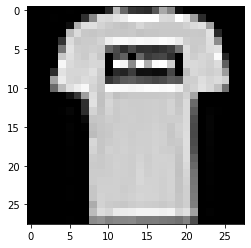

In [ ]:
plt.imshow(fashion_train.data[1], cmap="gray")
print(fashion_train.targets[1])

##### Test data 또한 가져와준다

In [ ]:
fashion_test.data = fashion_test.data/255.0
fashion_test.targets = fashion_test.targets

### Load dataset using DataLoader

Unsupervised learning 이므로 label 은 필요하지 않다, x data 만 가지고 오도록 한다

In [ ]:
batch_size = 256

# batch size 만큼 나누어서 data를 로드
train_loader = torch.utils.data.DataLoader(fashion_train.data ,batch_size=batch_size, shuffle=True,  drop_last=False)
# drop last를 False로 지정해 마지막까지 training 시킬 수 있도록 함

# batch size of test data => 전체 데이터를 하나의 배치로 크게 묶어줌
test_loader = torch.utils.data.DataLoader(fashion_test.data , batch_size=len(fashion_test.data), shuffle=False, drop_last=False)

In [ ]:
# 이미지의 size 재보기
for batch_idx,image in enumerate(train_loader):
    print(image[0].shape)
    break

torch.Size([28, 28])


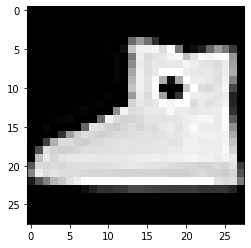

In [ ]:
for batch_idx, image in enumerate(train_loader):
    plt.imshow(image[98].reshape(28,28), cmap="gray")
    break

### AutoEncoder Network

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        # Encoder 와 Decoder 를 layer 하나로 주어 최대한 간단한 학습을 하도록 modeling
        # latent 의 size = 16
        self.encoder = nn.Linear(784, 16)
        self.decoder = nn.Linear(16, 784)
           
    def forward(self,x):
        z_vector = self.encoder(x)
        
        output = self.decoder(z_vector)
        
        return torch.sigmoid(output) # output range should be 0~1

In [ ]:
model = Autoencoder().to(device)
model

Autoencoder(
  (encoder): Linear(in_features=784, out_features=16, bias=True)
  (decoder): Linear(in_features=16, out_features=784, bias=True)
)

### Loss Function

In [ ]:
# MSE = Mean Squared Error
loss_function = nn.MSELoss()

### Parameters and Optimizer

In [ ]:
epoch = 100
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

### Train

In [ ]:
# training

total_batch = len(train_loader) # 전체 mini batch 의 갯수 (즉, 60000/256 = 234.xxxx => 235개)

for num_epoch in range(epoch):
    avg_loss = 0
    
    for batch_num, images in enumerate(train_loader):
        
        X = images.to(device)
        X = X.reshape(-1, 784)
        
        optimizer.zero_grad()
        
        output = model(X).to(device)
        
        loss = loss_function(output, X).to(device)
        loss.backward()
        
        optimizer.step()   # update
        
        avg_loss += (loss/total_batch) 
    
    # 10 epoch 마다 print
    if ((num_epoch+1) % 10 == 0):
        print("Epoch = {} loss = {:.6f}".format(num_epoch+1, avg_loss))

Epoch = 10 loss = 0.018572
Epoch = 20 loss = 0.017750
Epoch = 30 loss = 0.017605
Epoch = 40 loss = 0.017564
Epoch = 50 loss = 0.017560
Epoch = 60 loss = 0.017550
Epoch = 70 loss = 0.017554
Epoch = 80 loss = 0.017544
Epoch = 90 loss = 0.017542
Epoch = 100 loss = 0.017556


### Save model

In [ ]:
torch.save(model.state_dict(), './pre_trained/AutoEncoder_Basic.pth')

### Load model

In [ ]:
model = Autoencoder().to(device)

In [ ]:
model.load_state_dict(torch.load( './pre_trained/AutoEncoder_Basic.pth', map_location=device))

<All keys matched successfully>

### Test Model

In [ ]:
for batch_idx, image in enumerate(test_loader):
    with torch.no_grad():
        test_img = image.reshape(-1, 784).to(device)
        
        test_recon_x = model(test_img)

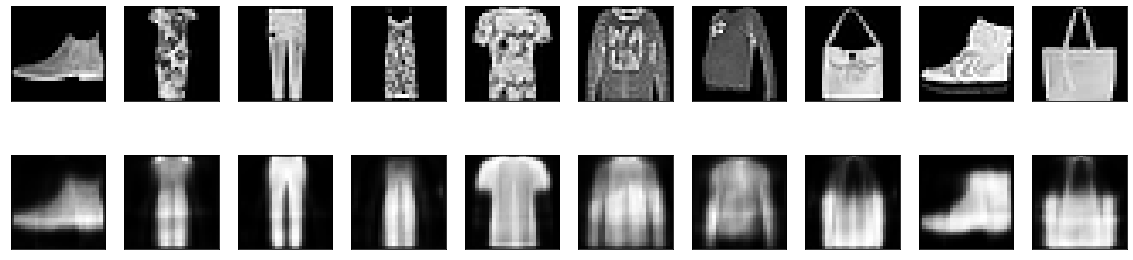

In [ ]:
n = 10  # 몇개를 보일것인가
plt.figure(figsize=(20, 5)) 

for i in range(n):
    #  Original data
    #  = pit.subplot(행의 갯수, 열의갯수, index )
    ax = plt.subplot(2, 10, i + 1) # i+1 = 1,2,3,4,5,6,7,8,9,10
    
    test_img = image[i*100].to(device) # 100개 단위로 출력 (특별한 이유는 없음)
    plt.imshow(test_img.cpu(), cmap='gray')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # ===================================================================
    
    ax = plt.subplot(2, 10, i+1+n) # 11,12,13,14,15,16,17,18,19,20
    
    recon_image = test_recon_x.data[i*100].reshape(28,28)
    plt.imshow(recon_image.cpu(), cmap='gray')

#     x, y 축을 보이고 싶다면 아래를 주석처리
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)